In [1]:
!git clone https://github.com/kelvis24/new-simple-point-clouds.git

Cloning into 'new-simple-point-clouds'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.15 MiB | 15.55 MiB/s, done.


In [ ]:
!pip install matplotlib plyfile torch numpy torch trimesh open3d rtree

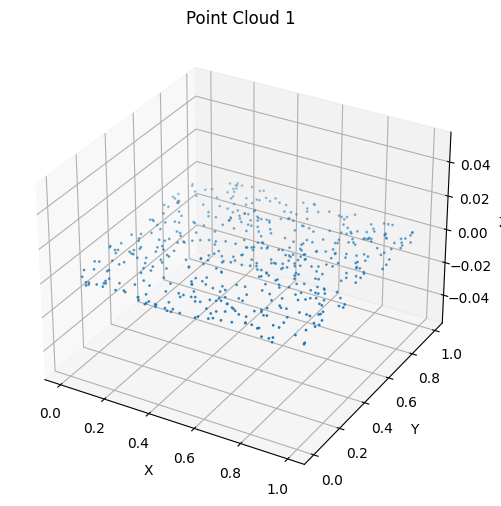

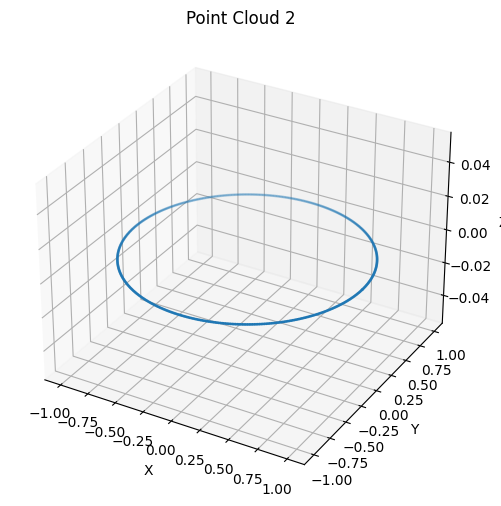

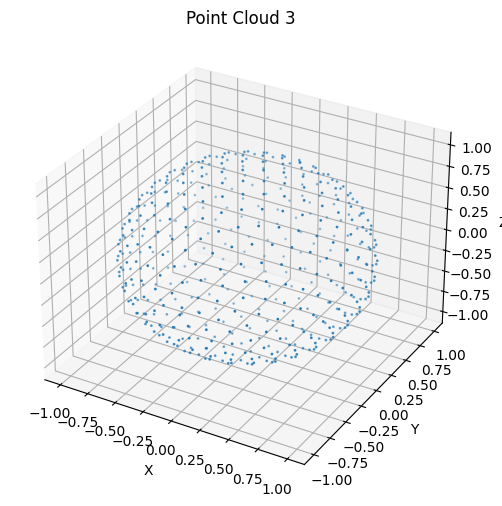

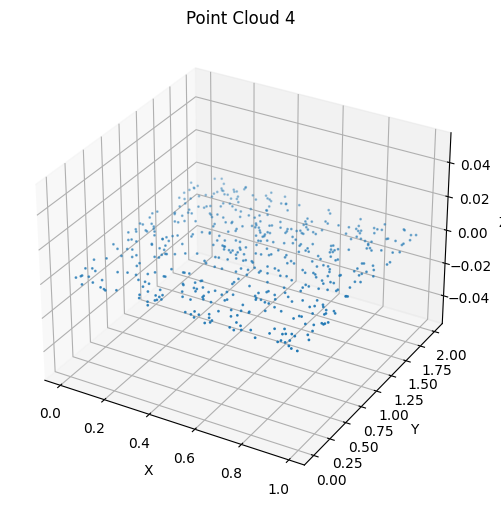

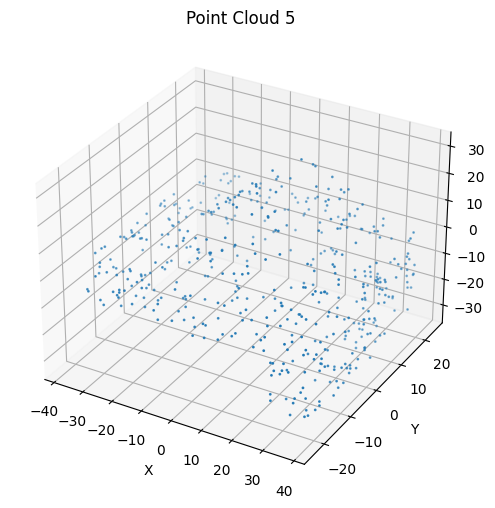

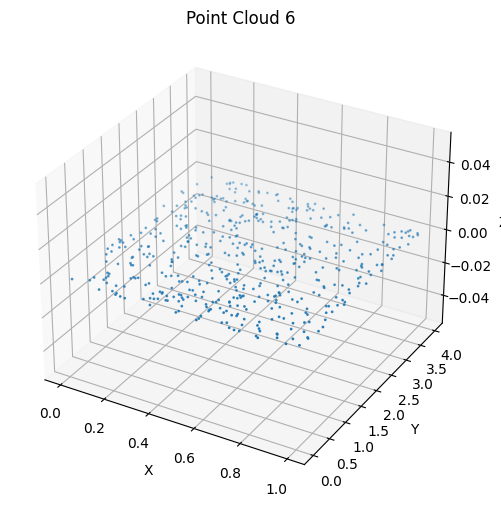

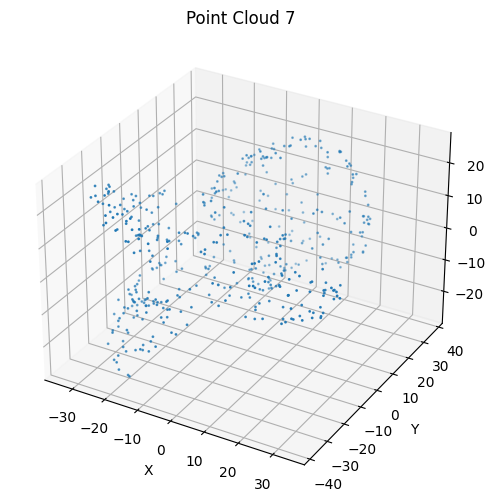

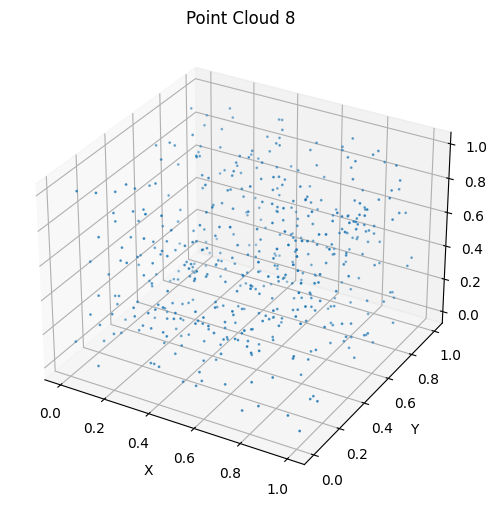

In [61]:
import numpy as np
import torch
from plyfile import PlyData
import os

# Custom function to load point cloud data from binary .ply files
def load_point_cloud_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    x = ply_data['vertex']['x']
    y = ply_data['vertex']['y']
    z = ply_data['vertex']['z']
    points = torch.tensor(np.column_stack((x, y, z)), dtype=torch.float32)
    return points

def resample_point_cloud(point_cloud, num_points):
    if len(point_cloud) == num_points:
        return point_cloud
    elif len(point_cloud) > num_points:
        indices = np.random.choice(len(point_cloud), size=num_points, replace=False)
        return point_cloud[indices]
    else:
        raise ValueError("Point cloud needs more points for resampling.")

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a single point cloud
def plot_point_cloud(points, title="Point Cloud", ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)  # 's' is the size of each point
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

# Load all point clouds from the directory
point_clouds_directory = '/content/new-simple-point-clouds'
point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]

# Find the number of points in the smallest point cloud
min_points = min(pc.shape[0] for pc in point_clouds)

# Resample all point clouds to match the smallest one
point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

for i, point_cloud in enumerate(point_clouds):
    plot_point_cloud(point_cloud, title=f"Point Cloud {i + 1}")
    plt.show()


Epoch 1/50, Loss: 0.3421851694583893
Epoch 11/50, Loss: 0.09362528473138809
Epoch 21/50, Loss: 0.01094141136854887
Epoch 31/50, Loss: 0.005630755331367254
Epoch 41/50, Loss: 0.0011794979218393564


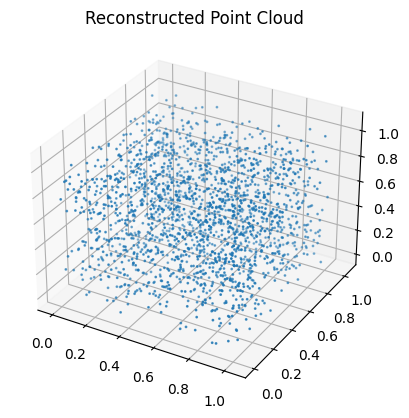

Skipping PCA due to a single data point.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self, output_size=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

# PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 3)

# PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder(output_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded, latent_vector

# Visualization function for point clouds
def plot_point_cloud(points, title="Point Cloud"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    ax.set_title(title)
    plt.show()

# Function to train the autoencoder
def train_autoencoder(point_cloud_data, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    point_cloud_data = point_cloud_data.to(device).unsqueeze(0).permute(0, 2, 1)

    model = PointNetAutoencoder(num_points=point_cloud_data.shape[-1], latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output, _ = model(point_cloud_data)
        loss = criterion(output, point_cloud_data.squeeze().permute(1, 0))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Visualizing the result and latent space
    with torch.no_grad():
        decoded_pc, latent_vector = model(point_cloud_data)
        decoded_pc = decoded_pc.view(point_cloud_data.shape[-1], 3).cpu().numpy()
        plot_point_cloud(decoded_pc, "Reconstructed Point Cloud")


                # Assuming latent_vector is the output from your model
        if latent_vector.dim() == 1 or latent_vector.size(0) == 1:
            print("Skipping PCA due to a single data point.")
        else:
            # PCA on latent vector for visualization
            pca = PCA(n_components=2)
            latent_vector_2d = pca.fit_transform(latent_vector.cpu().numpy())
            plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1])
            plt.title('Latent Space Representation (2D)')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
            plt.show()


# Example: Load your point cloud data here
point_cloud_data = point_clouds[2]

# Train the autoencoder
train_autoencoder(point_cloud_data, epochs=50, latent_size=128)


In [7]:
from torch.utils.data import Dataset, DataLoader

class PointCloudDataset(Dataset):
    def __init__(self, point_clouds):
        self.point_clouds = point_clouds

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]


In [ ]:
def train_autoencoder(point_clouds, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert list of point clouds to tensor and prepare DataLoader
    point_clouds_tensor = torch.stack(point_clouds).to(device)
    dataset = PointCloudDataset(point_clouds_tensor)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    model = PointNetAutoencoder(num_points=min_points, latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    latent_vectors = []
    for epoch in range(epochs):
        for data in dataloader:
            data = data.permute(0, 2, 1)  # Adjust dimensions [batch, channels, num_points]
            optimizer.zero_grad()
            output, latent = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    # Collect latent vectors for all point clouds
    with torch.no_grad():
        for data in dataloader:
            _, latent = model(data.permute(0, 2, 1))
            latent_vectors.append(latent.cpu())

    # Flatten the list of latent vectors and apply PCA for visualization
    latent_vectors = torch.cat(latent_vectors, 0)
    pca = PCA(n_components=2)
    latent_vectors_2d = pca.fit_transform(latent_vectors.numpy())
    plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1])
    plt.title('Latent Space Representation (2D)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# # Load and preprocess point clouds
# point_clouds_directory = '/content/new-simple-point-clouds'
# point_cloud_files = [f for f in os.listdir(point_clouds_directory) if f.endswith('.ply')]
# point_clouds = [load_point_cloud_from_ply(os.path.join(point_clouds_directory, f)) for f in point_cloud_files]
# min_points = min(pc.shape[0] for pc in point_clouds)
# point_clouds = [resample_point_cloud(pc, min_points) for pc in point_clouds]

# Train the autoencoder
train_autoencoder(point_clouds, epochs=50, latent_size=128)


In [12]:
# Adjusting the data permutation in the training function
def train_autoencoder(point_clouds, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(PointCloudDataset(point_clouds), batch_size=4, shuffle=True)

    model = PointNetAutoencoder(num_points=2048, latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            # Ensure data is [batch_size, num_channels (3), num_points]
            data = data.to(device).permute(0, 2, 1)
            optimizer.zero_grad()
            output, latent = model(data)
            # Make sure the output shape matches the target data shape
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

train_autoencoder(point_clouds, epochs=50, latent_size=128)



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 3, 500])) that is different to the input size (torch.Size([8192, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (3) must match the size of tensor b (500) at non-singleton dimension 2

Epoch 1/10, Loss: 0.32973889509836835
Epoch 2/10, Loss: 0.2831301689147949
Epoch 3/10, Loss: 0.17501058181126913
Epoch 4/10, Loss: 0.1340243344505628
Epoch 5/10, Loss: 0.09281253317991893
Epoch 6/10, Loss: 0.08797344068686168
Epoch 7/10, Loss: 0.08606645464897156
Epoch 8/10, Loss: 0.08298922330141068
Epoch 9/10, Loss: 0.08578651398420334
Epoch 10/10, Loss: 0.08018455406030019


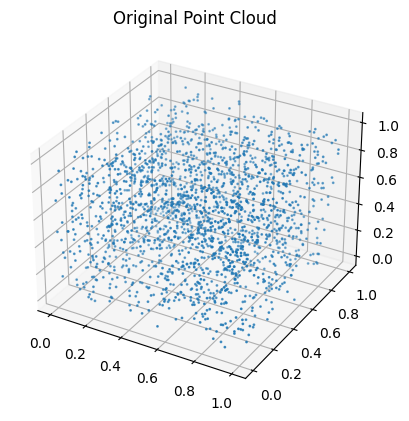

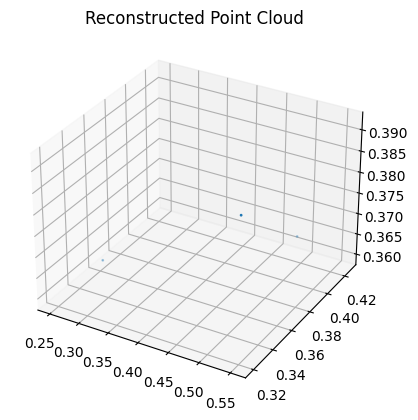

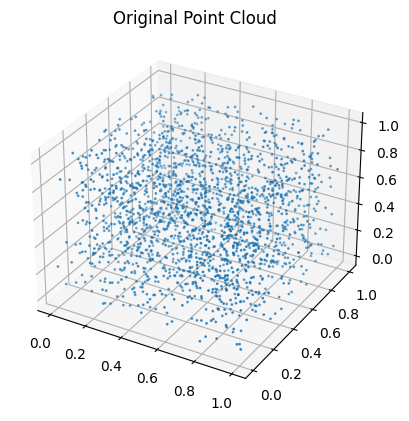

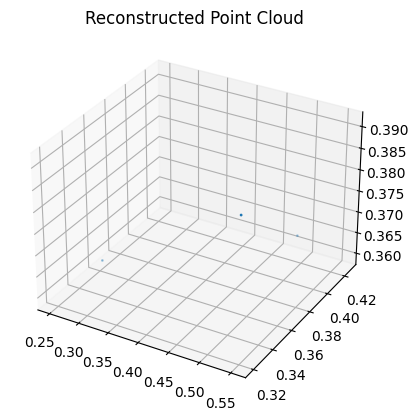

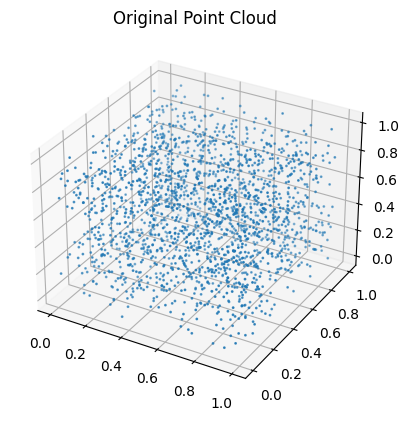

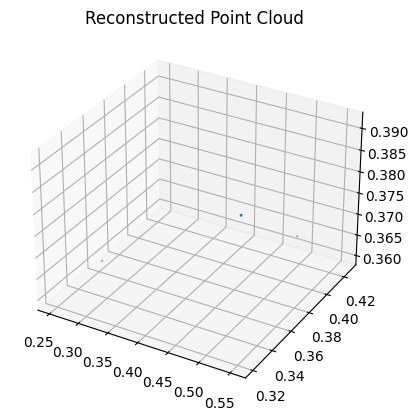

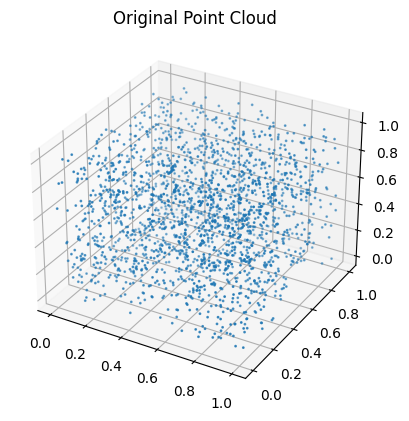

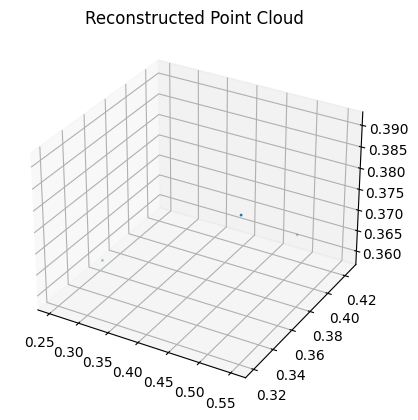

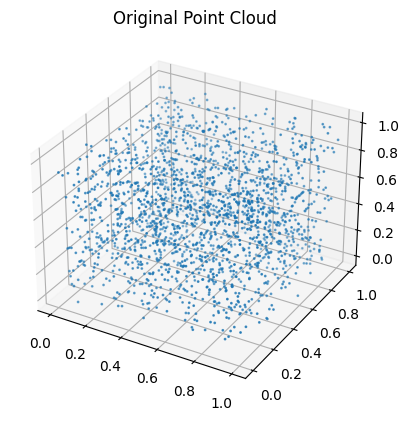

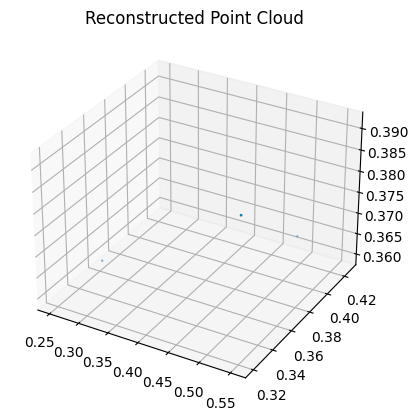

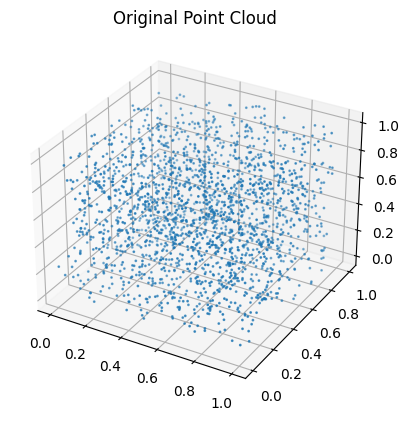

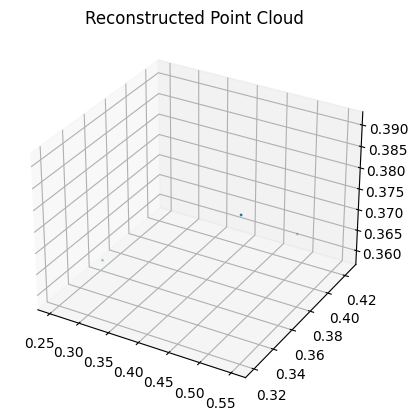

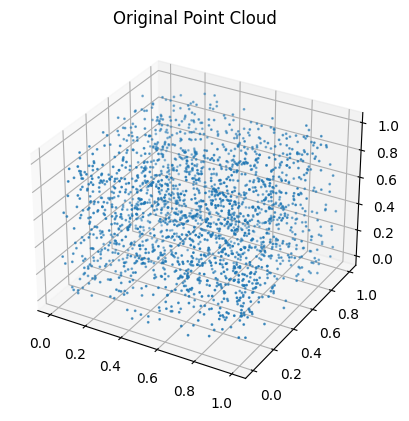

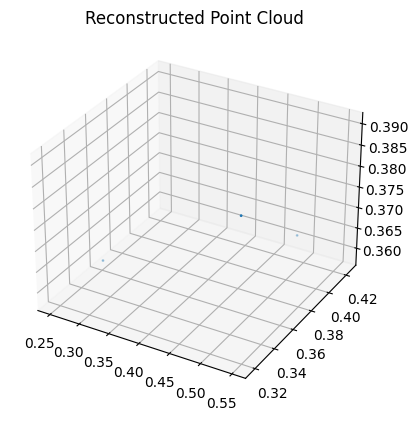

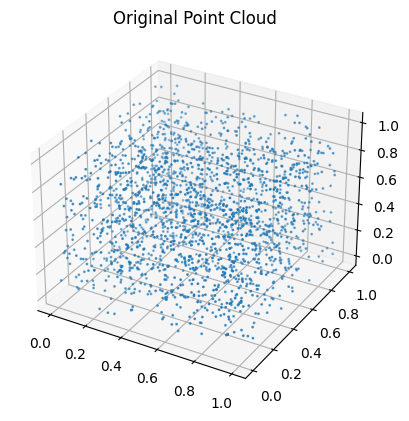

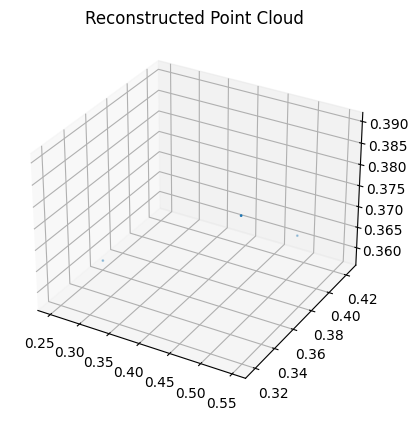

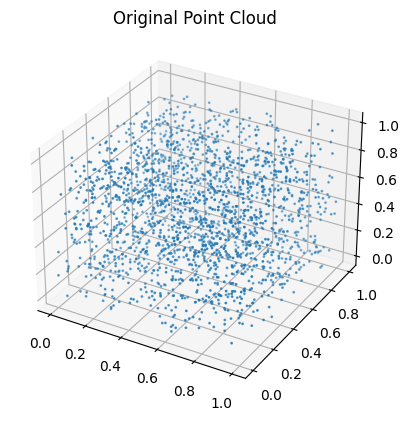

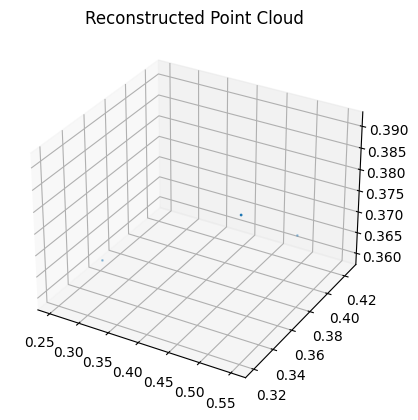

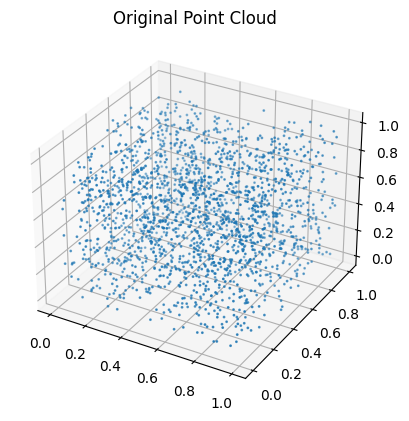

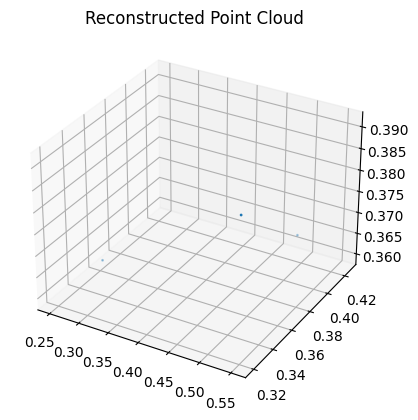

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

# PointNet Encoder
class PointNetEncoder(nn.Module):
    def __init__(self, output_size=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_size, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

# PointNet Decoder
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=500, latent_size=128):
        super(PointNetDecoder, self).__init__()
        self.num_points = num_points
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, self.num_points, 3)

# PointNet Autoencoder
class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=500, latent_size=128):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder(output_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded, latent_vector

# Dataset for point clouds
class PointCloudDataset(Dataset):
    def __init__(self, point_clouds):
        self.point_clouds = point_clouds

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        return self.point_clouds[idx]

# # Training function
# def train_autoencoder(point_clouds, epochs=50, latent_size=128):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     dataloader = DataLoader(PointCloudDataset(point_clouds), batch_size=4, shuffle=True)

#     model = PointNetAutoencoder(num_points=2048, latent_size=latent_size).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.MSELoss()

#     for epoch in range(epochs):
#         total_loss = 0
#         for data in dataloader:
#             data = data.to(device).permute(0, 2, 1)  # Adjust dimensions [batch, channels, num_points]
#             optimizer.zero_grad()
#             output, latent = model(data)
#             loss = criterion(output, data)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")

def visualize_reconstruction(model, point_cloud, device='cuda'):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert the point cloud to the correct format and device
    point_cloud_tensor = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)  # Shape [1, 3, num_points]

    # Get the reconstructed point cloud from the model
    with torch.no_grad():
        reconstructed, _ = model(point_cloud_tensor)
        reconstructed = reconstructed.squeeze().permute(1, 0).cpu().numpy()  # Shape [num_points, 3]

    # Plot the original point cloud
    plot_point_cloud(point_cloud.numpy(), title="Original Point Cloud")

    # Plot the reconstructed point cloud
    plot_point_cloud(reconstructed, title="Reconstructed Point Cloud")



def train_autoencoder(point_clouds, epochs=50, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = DataLoader(PointCloudDataset(point_clouds), batch_size=4, shuffle=True)

    model = PointNetAutoencoder(num_points=2048, latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.to(device).permute(0, 2, 1)  # Adjust dimensions to [batch_size, num_channels, num_points]
            optimizer.zero_grad()
            output, _ = model(data)
            # Adjust the target tensor to match the output tensor's shape before loss computation
            data = data.permute(0, 2, 1)  # Now data is [batch_size, num_points, num_channels] to match output
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")


    for pc in point_clouds:
        visualize_reconstruction(model, pc, device='cpu')





# Train the autoencoder
train_autoencoder(point_clouds, epochs=10, latent_size=128)


<ipython-input-62-9214f519382d>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_clouds = [torch.tensor(pc, dtype=torch.float) for pc in point_clouds]


Epoch 1/10, Loss: 0.3272477090358734
Epoch 2/10, Loss: 0.29125956694285077
Epoch 3/10, Loss: 0.19694904486338297
Epoch 4/10, Loss: 0.13214755803346634
Epoch 5/10, Loss: 0.10317511359850566
Epoch 6/10, Loss: 0.08622978876034419
Epoch 7/10, Loss: 0.0869215577840805
Epoch 8/10, Loss: 0.08200959116220474
Epoch 9/10, Loss: 0.08533619344234467
Epoch 10/10, Loss: 0.08110755681991577


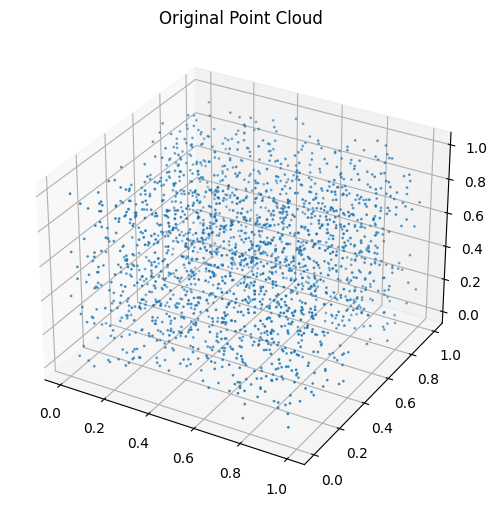

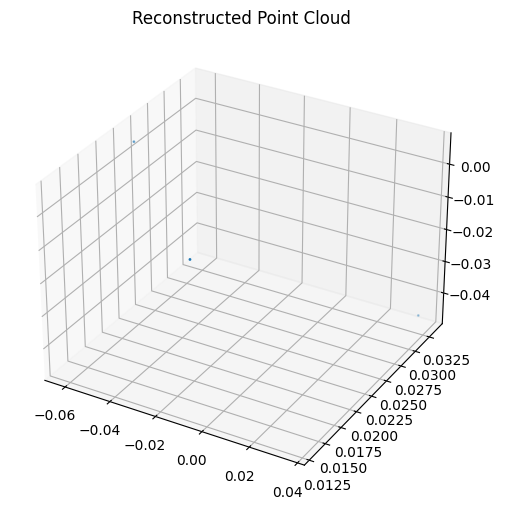

In [62]:
# Install required packages for Google Colab
# !pip install torch torchvision
# !pip install matplotlib
# !pip install scikit-learn ji

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader

# Generate synthetic point cloud data for demonstration
def generate_synthetic_point_clouds(batch_size, num_points=2048, num_dims=3):
    return [torch.rand(num_points, num_dims) for _ in range(batch_size)]

# PointNet Autoencoder Components
class PointNetEncoder(nn.Module):
    def __init__(self, output_size=128):
        super(PointNetEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = torch.max(x, 2, keepdim=False)[0]
        return x

class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetDecoder, self).__init__()
        self. num_points = num_points
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_points * 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, self.num_points, 3)

class PointNetAutoencoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=128):
        super(PointNetAutoencoder, self).__init__()
        self.encoder = PointNetEncoder(output_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)
    def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded, latent_vector

# Dataset for point clouds
class PointCloudDataset(Dataset):
    def __init__(self, point_clouds):
        self.point_clouds = point_clouds
    def __len__(self):
        return len(self.point_clouds)
    def __getitem__(self, idx):
        return self.point_clouds[idx]

# Training function
def train_autoencoder(point_clouds, epochs=10, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetAutoencoder(num_points=2048, latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    dataloader = DataLoader(PointCloudDataset(point_clouds), batch_size=4, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            # data = data.to(device).permute(0, 2, 1)
            # optimizer.zero_grad()
            # output, latent = model(data)

            data = data.to(device).permute(0, 2, 1)  # Adjust dimensions to [batch_size, num_channels, num_points]
            optimizer.zero_grad()
            output, _ = model(data)
            # Adjust the target tensor to match the output tensor's shape before loss computation
            data = data.permute(0, 2, 1)  # Now data is [batch_size, num_points, num_channels] to match output


            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")
    return model

# Visualization function for point clouds
def plot_point_cloud(points, title="Point Cloud"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)
    ax.set_title(title)
    plt.show()

# Generate synthetic point clouds
num_point_clouds = 10
point_clouds = generate_synthetic_point_clouds(num_point_clouds)

# Convert list of numpy arrays to tensors
point_clouds = [torch.tensor(pc, dtype=torch.float) for pc in point_clouds]

# Train the autoencoder
train_autoencoder(point_clouds, epochs=10, latent_size=128)

# Visualize the original and reconstructed point cloud (example with the first point cloud)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointNetAutoencoder(num_points=2048, latent_size=128).to(device)
model.eval()

with torch.no_grad():
    pc_tensor = point_clouds[0].to(device).unsqueeze(0).permute(0, 2, 1)  # Shape [1, 3, num_points]
    reconstructed, _ = model(pc_tensor)
    reconstructed = reconstructed.squeeze().permute(1, 0).cpu().numpy()  # Shape [num_points, 3]

plot_point_cloud(point_clouds[0].numpy(), "Original Point Cloud")
plot_point_cloud(reconstructed, "Reconstructed Point Cloud")


<ipython-input-69-177c08ad7aa7>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_clouds = [torch.tensor(pc, dtype=torch.float) for pc in generate_synthetic_point_clouds(10)]


Epoch 1/10, Loss: 0.32628388206164044
Epoch 2/10, Loss: 0.2751753528912862
Epoch 3/10, Loss: 0.1640392392873764
Epoch 4/10, Loss: 0.13202409197886786
Epoch 5/10, Loss: 0.08828926334778468
Epoch 6/10, Loss: 0.08690427988767624
Epoch 7/10, Loss: 0.08366391807794571
Epoch 8/10, Loss: 0.08490882068872452
Epoch 9/10, Loss: 0.08347798138856888
Epoch 10/10, Loss: 0.07967232912778854


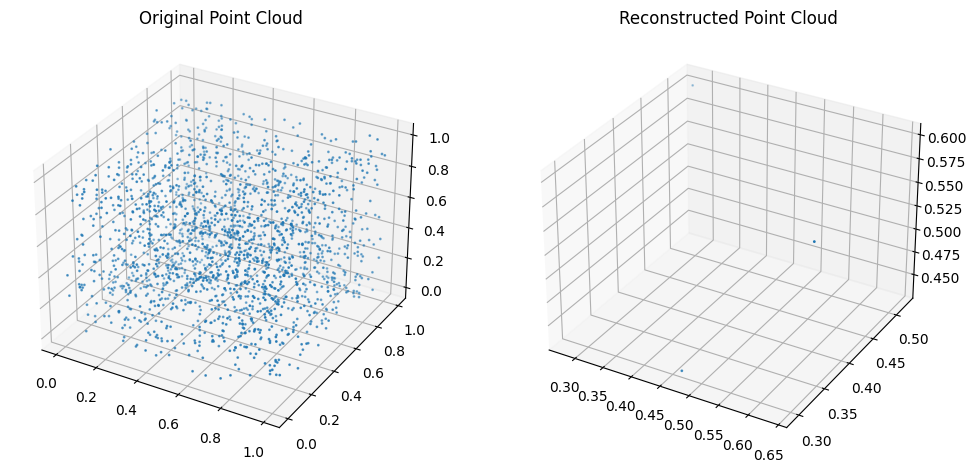

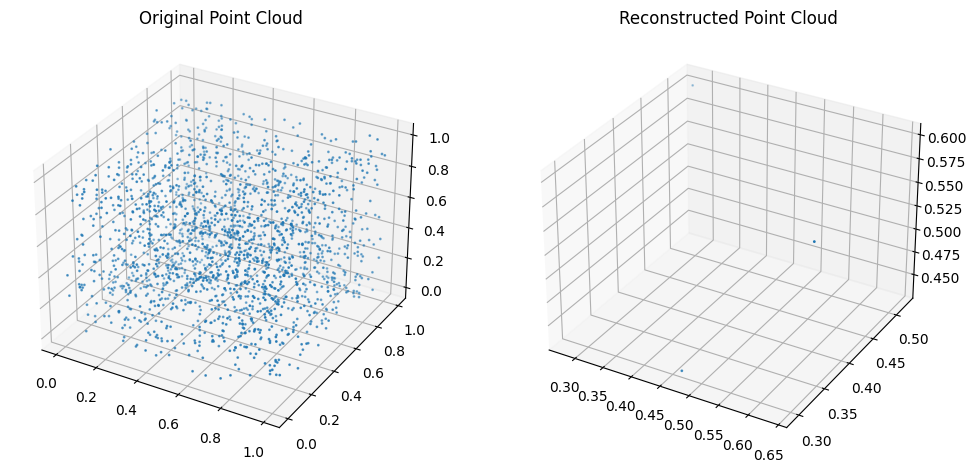

In [69]:
# Assuming all prior class definitions (PointNetEncoder, PointNetDecoder, PointNetAutoencoder, PointCloudDataset) are correct and included above this point.

import torch
from torch.utils.data import DataLoader

# Generate synthetic point clouds for demonstration
def generate_synthetic_point_clouds(batch_size, num_points=2048, num_dims=3):
    return [torch.rand(num_points, num_dims) for _ in range(batch_size)]

# Train the autoencoder and return the trained model
def train_autoencoder(point_clouds, epochs=10, latent_size=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetAutoencoder(num_points=2048, latent_size=latent_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    dataloader = DataLoader(PointCloudDataset(point_clouds), batch_size=4, shuffle=True)

    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for data in dataloader:
            data = data.to(device).permute(0, 2, 1)  # Adjust dimensions to [batch_size, num_channels, num_points]
            optimizer.zero_grad()
            output, _ = model(data)
            # Adjust the target tensor to match the output tensor's shape before loss computation
            data = data.permute(0, 2, 1)  # Now data is [batch_size, num_points, num_channels] to match output

            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")
    return model

# Visualization function for the original and reconstructed point clouds
def plot_point_clouds(original, decoded, title1="Original Point Cloud", title2="Reconstructed Point Cloud"):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2], s=1)
    ax1.set_title(title1)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(decoded[:, 0], decoded[:, 1], decoded[:, 2], s=1)
    ax2.set_title(title2)

    plt.show()


def visualize_reconstruction(trained_model, point_cloud, device='cpu'):
    trained_model.eval()  # Ensure the model is in evaluation mode
    point_cloud_tensor = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)  # Shape: [1, 3, num_points]

    with torch.no_grad():
        reconstructed, _ = trained_model(point_cloud_tensor)
        # Ensure the reconstructed output matches expected plotting shape
        reconstructed = reconstructed.permute(0, 2, 1).squeeze().cpu().numpy()  # Correct shape: [num_points, 3]

    # Plot the original and reconstructed point clouds using the correct function
    plot_point_clouds(point_cloud.cpu().numpy(), reconstructed, title1="Original Point Cloud", title2="Reconstructed Point Cloud")

# Generate synthetic point clouds and convert them to tensors
point_clouds = [torch.tensor(pc, dtype=torch.float) for pc in generate_synthetic_point_clouds(10)]

# Train the autoencoder
trained_model = train_autoencoder(point_clouds, epochs=10, latent_size=128)

# Visualize the original and reconstructed point cloud for the first point cloud
trained_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    pc_tensor = point_clouds[0].to('cpu').unsqueeze(0).permute(0, 2, 1)  # Shape: [1, 3, num_points]
    reconstructed, _ = trained_model(pc_tensor)
    reconstructed = reconstructed.squeeze().permute(1, 0).cpu().numpy()  # Correct shape: [num_points, 3]

plot_point_clouds(point_clouds[0].cpu().numpy(), reconstructed, "Original Point Cloud", "Reconstructed Point Cloud")
visualize_reconstruction(trained_model, point_clouds[0])


In [63]:
# Visualization function remains the same
def plot_point_clouds(original, decoded, title1="Original Point Cloud", title2="Decoded Point Cloud"):
    fig = plt.figure(figsize=(12, 6))

    # Original Point Cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2])
    ax1.set_title(title1)

    # Decoded Point Cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(decoded[:, 0], decoded[:, 1], decoded[:, 2])
    ax2.set_title(title2)

    plt.show()



def visualize_reconstruction(model, point_cloud, device='cpu'):
    model.eval()  # Ensure the model is in evaluation mode

    # Assuming point_cloud is a tensor of shape [num_points, 3]
    point_cloud_tensor = point_cloud.to(device).unsqueeze(0).permute(0, 2, 1)  # Correct shape: [1, 3, num_points]

    with torch.no_grad():
        reconstructed, _ = model(point_cloud_tensor)
        # Make sure to permute the reconstructed output to match the original's shape [num_points, 3] for visualization
        reconstructed = reconstructed.squeeze().permute(1, 0).cpu().numpy()

    # Plot the original and reconstructed point clouds using the correct function
    plot_point_clouds(point_cloud.cpu().numpy(), reconstructed, title1="Original Point Cloud", title2="Reconstructed Point Cloud")

Epoch 1/10, Loss: 0.32501377662022907
Epoch 2/10, Loss: 0.2750265846649806
Epoch 3/10, Loss: 0.16847997407118478
Epoch 4/10, Loss: 0.1303268571694692
Epoch 5/10, Loss: 0.09221869210402171
Epoch 6/10, Loss: 0.08551039298375447
Epoch 7/10, Loss: 0.08657517284154892
Epoch 8/10, Loss: 0.08202704787254333
Epoch 9/10, Loss: 0.0852291186650594
Epoch 10/10, Loss: 0.08102943499883015


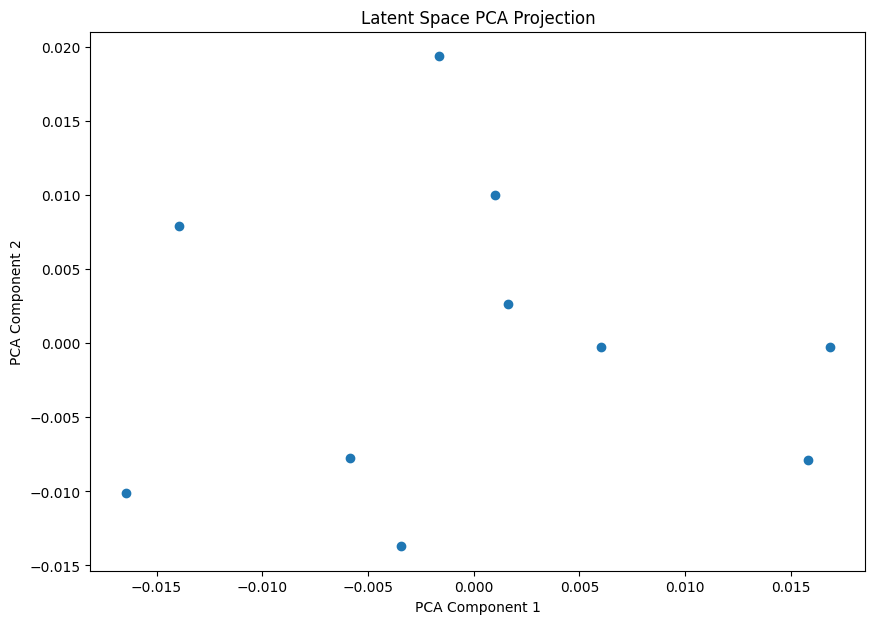

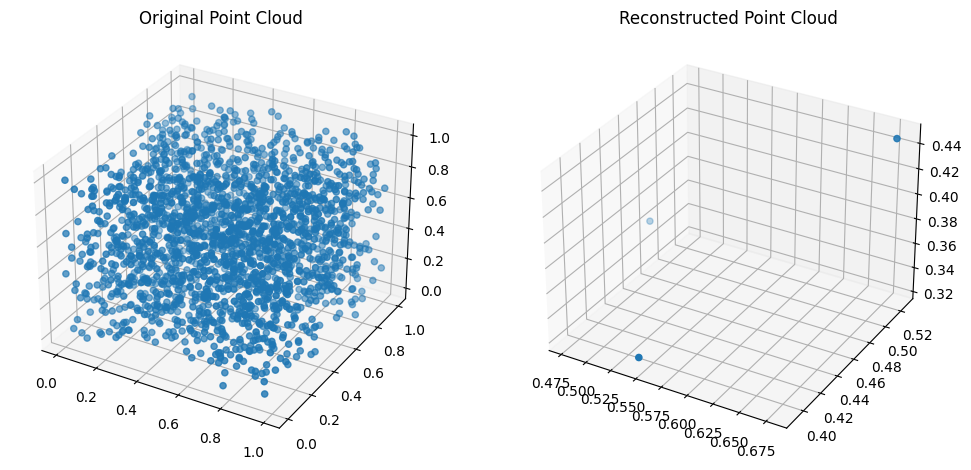

In [64]:
def collect_latent_vectors(model, point_clouds, device='cpu'):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for pc in point_clouds:
            pc_tensor = pc.to(device).unsqueeze(0).permute(0, 2, 1)
            _, latent_vector = model(pc_tensor)
            latent_vectors.append(latent_vector.cpu().numpy())
    return np.concatenate(latent_vectors, axis=0)

def plot_latent_space(latent_vectors):
    pca = PCA(n_components=2)
    components = pca.fit_transform(latent_vectors.reshape(latent_vectors.shape[0], -1))
    plt.figure(figsize=(10, 7))
    plt.scatter(components[:, 0], components[:, 1])
    plt.title("Latent Space PCA Projection")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Train the autoencoder and get the trained model
trained_model = train_autoencoder(point_clouds, epochs=10, latent_size=128)

# Collect latent vectors for a subset of the point clouds
latent_vectors = collect_latent_vectors(trained_model, point_clouds[:10], device='cpu')

# Plot the latent space
plot_latent_space(latent_vectors)

# Assuming 'point_clouds[0]' is one of the point clouds you want to visualize
visualize_reconstruction(trained_model, point_clouds[0], device='cpu')

